# Project \#3 - Face generation

### Deep Learning course -  A.Y. 2019-2020

Students:
- Simone Gayed Said
- Pierpasquale Colagrande


## Import of fundamental libraries
Herw we import fundamental libraries as TensorFlow, Numpy etc.

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
print("TensorFlow version", tf.__version__)

TensorFlow version 2.2.0-rc4


## Enabling and testing the TPU


In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.89.66.98:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.89.66.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.66.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)



## Input pipeline

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 2025 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [0]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
BUFFER_SIZE = 60000
INPUT_SIZE = 100
ORIGINAL_IMAGE_SIZE = [218,178, 3]
TARGET_IMAGE_SIZE = [64, 64, 3]
LATENT_SIZE = 16

In [0]:
AUTO = tf.data.experimental.AUTOTUNE

gcs_pattern = 'gs://celeba-public/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)


feature_dict = {
      "image": tf.io.FixedLenFeature([], tf.string),
  }


def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_image(example['image'])  
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [ORIGINAL_IMAGE_SIZE[0], ORIGINAL_IMAGE_SIZE[1], ORIGINAL_IMAGE_SIZE[2]])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1])) # crop and reshape the image 
  return image_tensor, tf.cast(1, tf.float32) # Adding a fake label

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

labeled_ds = load_dataset(filenames)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTO)

  return ds

train_dataset = prepare_for_training(labeled_ds, shuffle_buffer_size = BUFFER_SIZE)

Let's take a peek at the dataset we've created:

In [0]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

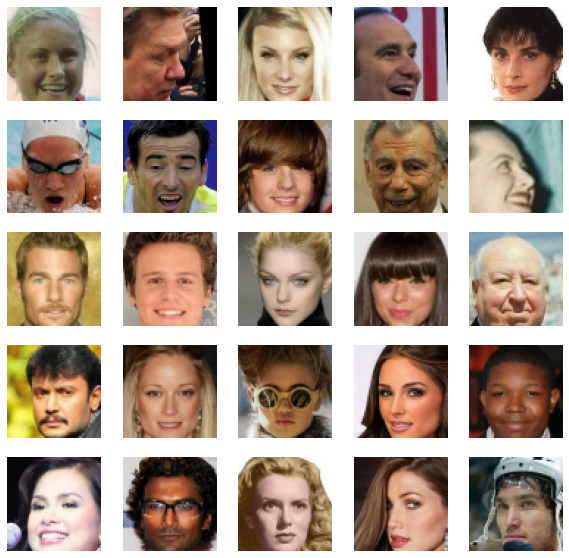

In [6]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy())

## Network model
Here, we build the network model.

In [0]:
"""
STANDARD AUTOENCODER - FOR SIMPLE RECONSTRUCTION
"""

# Function to create encoder
def create_autoencoder(image_size, latent_size):
  input_layer = Input(shape=image_size)
  x = GlobalAveragePooling2D()(input_layer)
  output_layer = Dense(5, activation="softmax")(x)
  model = Model(inputs=input_layer, outputs=output_layer)

  return model

###Train the model

In [17]:
with strategy.scope():
  autoencoder = create_autoencoder(TARGET_IMAGE_SIZE, LATENT_SIZE)
  autoencoder.compile(loss='mse', optimizer=Adam(0.001))
  autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [18]:
train_dataset = prepare_for_training(labeled_ds)
autoencoder.fit(train_dataset, verbose=1, epochs=20, steps_per_epoch=202599//BATCH_SIZE)

Epoch 1/20
1582/1582 [==============================] - 20s 12ms/step - loss: 0.6400
Epoch 2/20
1582/1582 [==============================] - 13s 8ms/step - loss: 0.6400
Epoch 3/20
1582/1582 [==============================] - 13s 8ms/step - loss: 0.6400
Epoch 4/20
1582/1582 [==============================] - 13s 8ms/step - loss: 0.6400
Epoch 5/20
1582/1582 [==============================] - 13s 8ms/step - loss: 0.6400
Epoch 6/20
1582/1582 [==============================] - 13s 8ms/step - loss: 0.6400
Epoch 7/20
1582/1582 [==============================] - 13s 8ms/step - loss: 0.6400
Epoch 8/20
1500/1582 [===========================>..] - ETA: 0s - loss: 0.6400

KeyboardInterrupt: ignored